## Assumptions
1. No submodules in the repo
2. Since tree sitter parser generates only syntax tree, so during updation only considering syntactic change and not semantic change for a call since for semantic change i.e. contextual change complete code files needs to be inputted and since we are using a comparitively smaller LLM input tokens starts limiting for larger code files.
3. All original modules are syntactically correct.
4. Naming conventions are strictly followed across all the files in the repo
5. For this assignment assuming only python repositories.

### Functions to parse repo and made a graph structure over it

In [1]:
!pip install tree-sitter tree-sitter-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.6/542.6 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.6/130.6 kB 9.6 MB/s eta 0:00:00


In [2]:
import os
from tree_sitter import Language, Parser
import tree_sitter_python as tspython
import networkx as nx
import matplotlib.pyplot as plt
from pygments import highlight
from pygments.lexers import PythonLexer
from pygments.formatters import TerminalFormatter

# Parser Intializer
PY_LANGUAGE = Language(tspython.language())
parser = Parser(PY_LANGUAGE)

# Function to parse file in the repo to get the parser generated syntax tree
def parse_file(file_path):
    '''
    Parameters: file_path = File path of the code file in repo
    Return: Parser generated syntax tree
    '''
    with open(file_path, 'rb') as file:
        code = file.read()
        return parser.parse(code)


In [3]:
# To extract function defined in a file
def extract_functions(node, module_name, class_name=None):
    '''
    Parameters: node = Root node of the syntax tree for that module
                class_name = name of the class in the module
                module_name = Name of the code file
    Return: A list containing extracted function_name and function node as a tuple
            where when function is defined in a class it's name is given as {module_name}.{class_name}.{func_name}
            and as {module_name}.{func_name} in the other case
    '''
    functions = []
    for child in node.children:
        if child.type == 'function_definition':
            func_name = child.child_by_field_name('name').text.decode('utf-8')
            if class_name: # class defined function
                func_name = f"{module_name}.{class_name}.{func_name}"
            else: # module defined function
                func_name = f"{module_name}.{func_name}"
            functions.append((func_name, child))
        elif child.type == 'class_definition':
            child_class_name = child.child_by_field_name('name').text.decode('utf-8')
            functions.extend(extract_functions(child.child_by_field_name('body'), module_name, child_class_name))
    return functions

In [4]:
# Function to get aliased name from a import statement of either a module, class or function
def get_aliased_name(alias_node):
    '''
    Parameter: alias_node = Alias Node from import statement
    Return: module name and alias name
    '''
    module_name = None
    alias_name = None
    for child in alias_node.children:
        if child.type == 'aliased_import':
            module_name = child.child_by_field_name('name').text.decode('utf-8')
            alias_name = child.child_by_field_name('alias').text.decode('utf-8')
    return module_name, alias_name

# Function to get all the imported module and their corresponding class and functions in a module
def parse_imports(node, imports):
    '''
    Parameters: node = Root node of the syntax tree for that module
                imports = Dictionary to store imported module_name (key) and function and class names (as values)
                         A class/ function name is stored in their corresponding lists as a tuple (original_name, alias_name)
    Return: None
    '''
    if node.type == 'import_statement':
        for child in node.children_by_field_name('name'):
            module_name= child.text.decode('utf-8')
            module, alias_name = get_aliased_name(child)
            module_name = module if module else module_name
            imports[module_name] = {'class':[], 'function':[]}
            if alias_name:
                imports[module_name]['as'] = alias_name
    elif node.type == 'import_from_statement':
        module_name = node.child_by_field_name('module_name').text.decode('utf-8')
        imports[module_name] = {'class':[], 'function':[]}
        for child in node.children_by_field_name('name'):
            atr_name = child.text.decode('utf-8')
            atr, alias_name = get_aliased_name(child)
            atr_name = atr if atr else atr_name
            if atr_name[0].isupper():
                imports[module_name]['class'].append((atr_name, alias_name))
            else:
                imports[module_name]['function'].append((atr_name, alias_name))
    for child in node.children:
        parse_imports(child, imports)

In [5]:
# To check whether the given name is a module imported in the code file
def is_module(name, imports):
    '''
    Parameters: name = name to check
                imports = Dictionary which contains imported module_name (key) and function and class names (as values) 
    Return: Tuple (boolean, module_name)
    '''
    for module, atr in imports.items():
        if name == module or ('as' in atr and name == atr['as']):
            return (True, module)
    return (False, '')

# To check whether the given name is a class imported in the code file
def is_class(name, imports):
    '''
    Parameters: name = name to check
                imports = Dictionary which contains imported module_name (key) and function and class names (as values) 
    Return: List [boolean, class_name, module_name from which it is imported]
    '''
    for module_name, atr in imports.items():
        for class_name in atr['class']:
            if name in class_name:
                return [True, class_name[0], module_name]
    return [False, '', '']
    
# To extract class objects intialized in the given module
def extract_class_objects(node, module_name, class_objects, imports):
    '''
    Parameters: node = Root node of the syntax tree for that module
                module_name = module name of the code file(name of code file)
                class_objects = Dictionary to store class objects for that module
                                where object name is key and value as class name which is in the format {module name where it is defined}.{class name}
                imports = Dictionary which contains imported module_name and corresponding function/class names 
    Return: None
    '''
    for child in node.children:
        if child.type == 'assignment':
            left = child.child_by_field_name('left')
            right = child.child_by_field_name('right')
            if left and right and right.type == 'call':
                obj_name = left.text.decode('utf-8')
                right_name = right.child_by_field_name('function').text.decode('utf-8')
                class_atr = is_class(right_name, imports) 
                class_name =  f"{class_atr[2]}.{class_atr[1]}" if class_atr[1] else ''  # intra module class object if using direct import
                func_node = right.child_by_field_name('function')
                if func_node.type == 'attribute': # intra module class object using from import
                    obj = func_node.child_by_field_name('object').text.decode('utf-8')
                    func = func_node.child_by_field_name('attribute').text.decode('utf-8')
                    module = is_module(obj, imports)
                    class_atr = is_class(func, imports)
                    if module[0] and class_atr[0] and (module[1] == class_atr[2]):
                        class_name = f"{class_atr[2]}.{class_atr[1]}"
                elif len(class_name) == 0 and right_name[0].isupper(): # inter module class object 
                    class_name = f"{module_name}.{right_name}"
    
                if obj_name not in class_objects and class_name:
                    class_objects[obj_name] = class_name
        elif child.children:
            extract_class_objects(child, module_name, class_objects, imports)
 

In [6]:
# To check whether the given name is a function imported in the code file
def is_intra_function(name, imports):
    '''
    Parameters: name = name to check
                imports = Dictionary which contains imported module_name (key) and function and class names (as values) 
    Return: Tuple (boolean, class name in the format {module name where it is defined}.{class name})
    '''
    for module_name, atr in imports.items():
        for func_name in atr['function']:
            if name in func_name:
                return (True, f"{module_name}.{func_name[0]}")
    return (False, '')

# To extract function calls from the given module
def find_function_calls(node, module_name, function_names, class_objects, imports, calls):
    '''
    Parameters: node = Root node of the syntax tree for that module
                module_name = module name of the code file(name of code file)
                function_name = Dictionary containing all the defined functions in the repo
                class_objects = Dictionary containing intialized class object name and class name for the given module
                imports = Dictionary containing imported module_name and corresponding function/class names 
                calls: Dictionary which would store caller nodes for the defined repo functions
    Return: None
    '''
    if node.type == 'call':
        func_node = node.child_by_field_name('function')
        func_name =  func_node.text.decode('utf-8')
        if func_node.type == 'attribute': # Class function call and Intra function call using module import
            obj = func_node.child_by_field_name('object').text.decode('utf-8')
            func = func_node.child_by_field_name('attribute').text.decode('utf-8')
            full_name = f"{obj}.{func}"
            if obj in class_objects:
                full_name = f"{class_objects[obj]}.{func}"
            if full_name in function_names:
                if full_name not in calls:
                    calls[full_name] = [node]
                else:
                    calls[full_name].append(node)
        elif func_node.type == 'identifier' and not func_name[0].isupper(): # Intra/Inter function call
            func_atr = is_intra_function(func_name, imports)
            func_name = func_atr[1] if func_atr[0] else f"{module_name}.{func_name}"
            if func_name in function_names:
                if func_name not in calls:
                    calls[func_name] = [node]
                else:
                    calls[func_name].append(node)
    for child in node.children:
        find_function_calls(child, module_name, function_names, class_objects, imports, calls)


### Graph properties
1. Two types of nodes i.e. 'function' and 'call'.
2. For a 'function' node, there would be a edge between its all caller nodes.
3. Naming convention for a caller node is {module where the call occurred}.{function name in the same convention as described in the above section}_counter where counter is the count of that call for that function

In [7]:
# Function to build the graph
def build_graph(repo_path):
    '''
    Parameters: repo_path = Path of the repo
    Return: Graph structure of the given repo
    '''
    G = nx.DiGraph()
    functions = {}

    for root, _, files in os.walk(repo_path):
        for file in files:
            if file.endswith('.py'):
                file_path = os.path.join(root, file)
                module_name = os.path.basename(file_path).replace('.py', '')
                tree = parse_file(file_path)
                file_functions = extract_functions(tree.root_node, module_name)
                
                for func_name, func_node in file_functions:
                    if func_name not in functions:
                        functions[func_name] = func_node
                        G.add_node(func_name, ast_node=func_node, node_type='function', file_path = file_path)
     
    for root, _, files in os.walk(repo_path):
        for file in files:
            if file.endswith('.py'):
                file_path = os.path.join(root, file)
                module_name = os.path.basename(file_path).replace('.py', '')
                tree = parse_file(file_path)
                # Find calls in the entire module
                class_objects = {}
                module_calls = {}
                imports = {}
                parse_imports(tree.root_node, imports) 
                extract_class_objects(tree.root_node, module_name, class_objects, imports)
                find_function_calls(tree.root_node, module_name, functions, class_objects, imports, module_calls)
                # Add edges for function calls
                module_level_calls = set()
                
                for called_func, call_nodes in module_calls.items():
                    if called_func in functions:
                        i = 1
                        for node in call_nodes:
                            called_func_name = f"{module_name}.{called_func}_{i}"
                            G.add_node(called_func_name, ast_node=node, node_type='call', file_path = file_path)
                            G.add_edge(called_func, called_func_name, relation = 'call')
                            i+=1
                    
    return G


In [8]:
# Function to visualize the graph
def visualize_graph(G):
    '''
    Parameter: G = graph structure obtained for a repo
    Return: Outputs the graph on plot
    '''
    pos = nx.spring_layout(G)
    plt.figure(figsize=(20, 15))
    
    node_colors = ['lightblue' if G.nodes[node].get('node_type') == 'function' else 'yellow' for node in G.nodes()]
    
#     nx.draw(G, pos, with_labels=True, node_color=node_colors, node_size=2000, font_size=8, arrows=True)
    nx.draw(G, pos, with_labels=True, node_color=node_colors, node_size=2800, font_size=10,arrows=True)
#     edge_labels = {(u, v): d['relation'] for u, v, d in G.edges(data=True)}
#     nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
    edge_labels = nx.get_edge_attributes(G, 'relation')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
    plt.title("Function Call Graph")
    plt.axis('off')
    plt.show()

def print_node_info(G):
    for node in G.nodes:
        print(f"Node: {node}")
        print(f"Node Type: {G.nodes[node].get('node_type', 'unknown')}")
        if 'ast_node' in G.nodes[node]:
            ast_node = G.nodes[node]['ast_node']
            print("AST Node Type:", ast_node.type)
            print("Source Code:")
            print(highlight(ast_node.text.decode('utf-8'), PythonLexer(), TerminalFormatter()))
        else:
            print("(Module node)")
        print("\n" + "="*50 + "\n")



### Test case to verify the graph structure for a repo

In [9]:
def run_tests():
    test_repo = 'test_repo'
    os.makedirs(test_repo, exist_ok=True)

    # Main file
    with open(os.path.join(test_repo, 'main.py'), 'w') as f:
        f.write('''
from helper import Helper

def main():
    helper = Helper()
    helper.greet("Alice")
    print_message("Hello from main")

def print_message(msg):
    print(msg)

if __name__ == "__main__":
    main()
''')

    # Helper file
    with open(os.path.join(test_repo, 'helper.py'), 'w') as f:
        f.write('''
class Helper:
    def greet(self, name):
        print(f"Hello, {name}!")

def unused_function():
    pass
''')

    graph = build_graph(test_repo)
    visualize_graph(graph)
    # Verify graph structure
    assert 'main.main' in graph.nodes
    assert 'main.print_message' in graph.nodes
    assert 'helper.Helper.greet' in graph.nodes
    assert 'helper.unused_function' in graph.nodes
    assert graph.has_edge('helper.Helper.greet', 'main.helper.Helper.greet_1')
    assert graph.has_edge('main.print_message', 'main.main.print_message_1')

    print("All tests passed!")
    print("Please check the below graph for the graph visualization.")


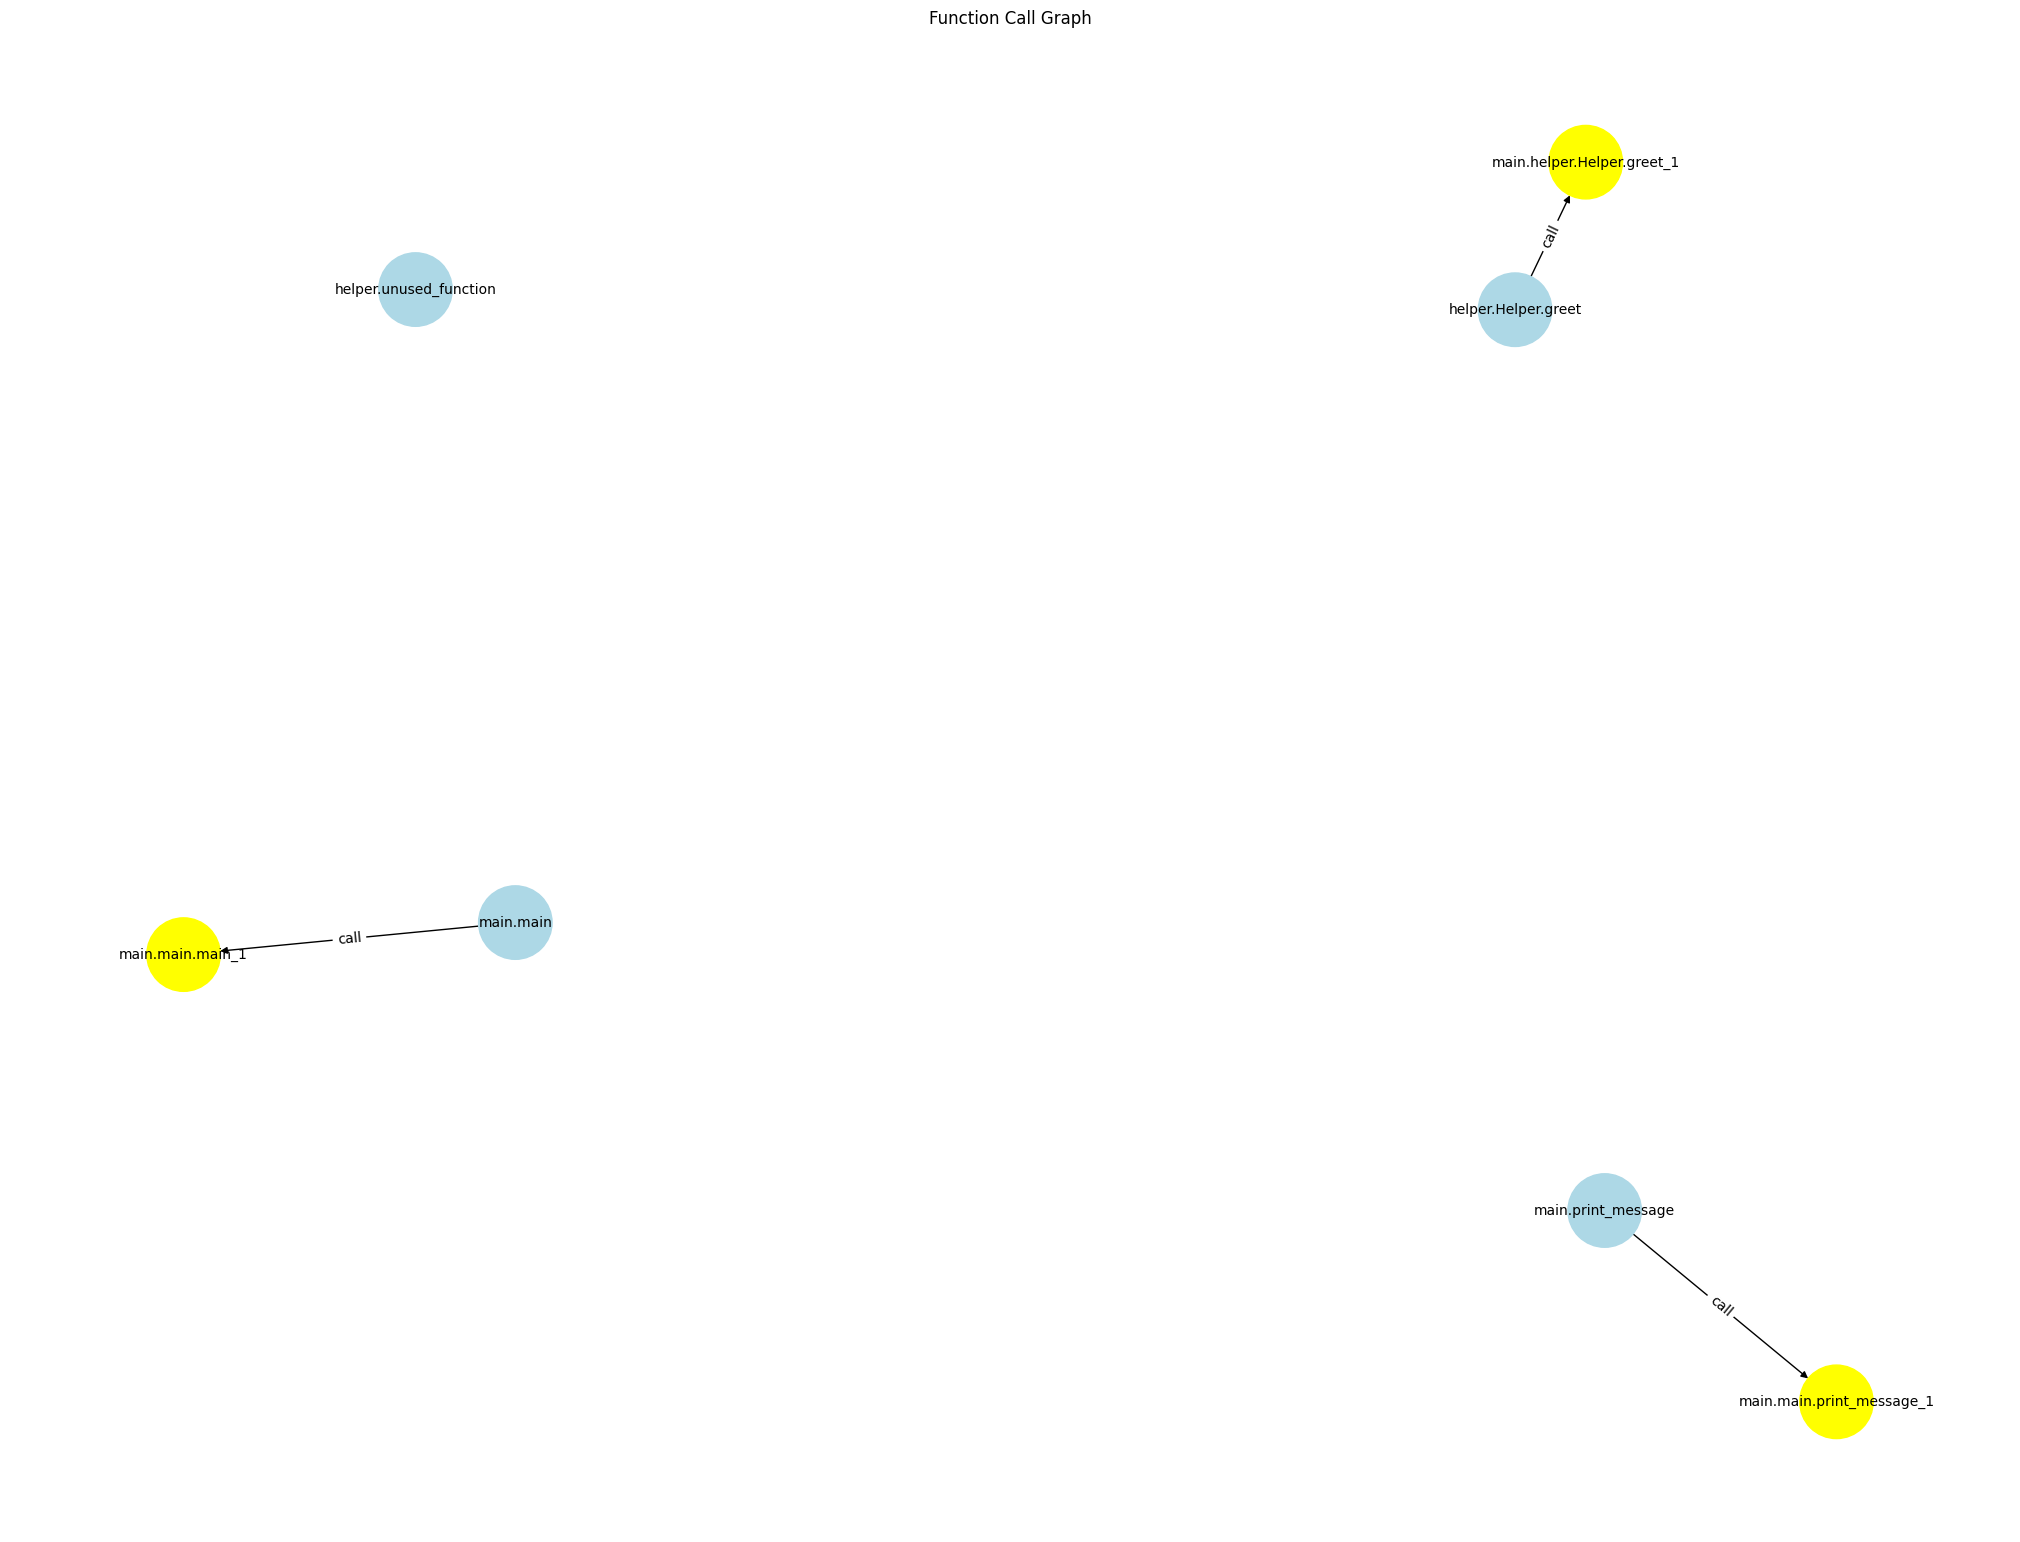

All tests passed!
Please check the below graph for the graph visualization.


In [10]:
run_tests()

### Section to transform the code using LLMs

In [11]:
!pip install transformers torch

### Intiailizing the LLM

In [12]:
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch
model_name = "codellama/CodeLlama-7b-Instruct-hf"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name, torch_dtype=torch.float16, device_map="auto")

tokenizer_config.json:   0%|          | 0.00/1.59k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/411 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/646 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/25.1k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.50G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

### Functions to get the modified code files


In [13]:
import re
# Function to extract code from the generated text from the LLM
def extract_code_from_markdown(markdown_text):
    '''
    Parameter: markdown_text = Output text from the LLM 
    Return: Modified code snippet
    '''
    code_block_pattern = r'```(.*?)```'
    matches = re.findall(code_block_pattern, markdown_text, re.DOTALL)
    # Remove the language identifier if present (e.g., ```python)
#     code_blocks = [match.split('\n', 1)[-1] if '\n' in match else match for match in matches]
    return matches[1]

In [14]:
# Function to generate modified function code using LLM
def generate_modified_function_code(old_code, modification_instruction):
    '''
    Parameter: old_code = Function code to modify extracted from the function graph node
               modification_instruction = Instruction feeded to the prompt for the modification of code
    Return: LLM Output Text
    '''
    
    prompt = f"""
    The following function which is enclosed within code block needs to be modified based on the instruction provided:
    ```
    {old_code}
    ```
    Instruction: {modification_instruction}
    Note: Maintain the code's indentation for the modifed code as the original code.
    Modified Code:
    """
     
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
        
    outputs = model.generate(
            **inputs,
            max_length=512,
            temperature=0.2,
            do_sample=True,
            top_k=50,
            num_return_sequences=1
    )
        
    generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return extract_code_from_markdown(generated_text)

# Function to generate updated call code using OpenAI Codex
def generate_updated_call_code(function_name, class_name, original_function, modified_function, original_caller):
    '''
    Parameter: function_name = Name of the function which is updated
               class_name = Name of the class if function is class defined
               original_function = Original function code
               modified_function = Updated function code
               original_caller = Function's caller code which needs to be modified
    Return: LLM Output Text
    '''
    
    extra_instr = f"of class {class_name} " if class_name else ''
    prompt = f"""
    The python function {function_name} {extra_instr}is modified. Both original and modified code are given, compare them syntactically and semantically.
    Original Function:
    '''
    {original_function}
    '''
    Modified Function:
    '''
    {modified_function}
    '''
    Now, after comparing the function if the function is modified update the original caller (which is enclosed within code block) to match the new signature:
    ```{original_caller}```
    Modified Caller Code:
    """
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
    outputs = model.generate(
            **inputs,
            max_length=512,
            temperature=0.4,
            top_k=20,
            top_p=0.8,
            do_sample=True,
            num_return_sequences=1
    )
        
    generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return extract_code_from_markdown(generated_text)

In [15]:
# Function to modify function and calls in the code base
def modify_function_and_calls(graph, module_name, class_name, function_name, modification_instruction):
    '''
    Parameter: graph = graph structure obtained for a repo
               module_name = Name of the module where function is defined
               class_name = Name of the class if function is class defined
               function_name = Name of the function which needs to be updated
               modification_instruction = Instruction feeded to the function update prompt for the modification of code
    Return: A dictionary containing all the modified code files with the original file paths, original function code, updated function code
    '''
    
    if class_name:
        function_name = f"{module_name}.{class_name}.{function_name}"
    else:
        function_name = f"{module_name}.{function_name}"
    function_graph_nodes = [node for node, attr in graph.nodes(data=True) if attr['node_type'] == 'function']
    if function_name not in function_graph_nodes:
        print(f"ERROR {function_name} not present in any file in the repository")
        return {}
    
    fun_graph_node = graph.nodes[function_name]
    function_node = fun_graph_node['ast_node']
    file_path = fun_graph_node['file_path']
    with open(file_path,'r') as f:
        source_code = f.read()
    modified_code_files = {}
    # Modify the function definition
    start_byte = function_node.start_byte
    end_byte = function_node.end_byte
    old_code = function_node.text.decode('utf-8')
    new_code = generate_modified_function_code(old_code, modification_instruction)
    
    # Modify the function calls
    for caller in list(graph.neighbors(function_name)):
        call_graph_node = graph.nodes[caller]
        call_node = call_graph_node['ast_node']
        caller_file_path = call_graph_node['file_path']
        if caller_file_path not in modified_code_files:
            with open(caller_file_path,'r') as f:
                code = f.read()
            modified_code_files[caller_file_path] = code
        caller_source_code = modified_code_files[caller_file_path]
        start_byte = call_node.start_byte
        end_byte = call_node.end_byte
        old_call = call_node.text.decode('utf-8')
        new_call = generate_updated_call_code(function_name, class_name, old_code, new_code, old_call)
        caller_source_code = caller_source_code.replace(old_call, new_call, 1)
        modified_code_files[caller_file_path] = caller_source_code
    modified_code_files[file_path] = source_code.replace(old_code, new_code, 1)
    return {'modified_code_files':modified_code_files, 'original_func_code': old_code,'updated_func_code': new_code}
 

### Functions needed for transformation analysis

In [16]:
# To extract the parameter info for a given parameter node
def extract_param_info(param_node):
    '''
    Parameter: param_node: Tree child parameter node
    Return: Parameter Name
    '''
    param_name = None
    default_value = None
    if param_node.type == 'identifier':
        param_name = param_node.text.decode('utf8')
    elif param_node.type in ['default_parameter', 'typed_default_parameter']:
        param_name = param_node.child_by_field_name('name').text.decode('utf8')
        default_value = param_node.child_by_field_name('value').text.decode('utf8')
    elif param_node == 'typed_parameter':
        for child in param_node.children:
            if child.type == 'identifier':
                param_name = param_node.text.decode('utf8')
            
    return param_name

# To extract the all the input parameters for a function
def find_function_params(func_node):
    '''
    Parameter: func_node = Tree function node 
    Return: List of all input function parameter name
    '''
    if func_node.type == 'function_definition':
        params = func_node.child_by_field_name('parameters')
        if params:
            return [extract_param_info(param) for param in params.children 
                    if param.type in ('identifier', 'default_parameter', 'typed_parameter', 'typed_default_parameter')]
    
    return []

### Evaluation Function
Note: Along with these evaluation metrics, human evaluation is done which I believe is the most accurate metric for code generation 

In [17]:
import ast
# To check the transformed code for any compilation error
def static_analysis(transformed: str):
    '''
    Parameter: transformed = updated code for a file
    Checks whether the code can be compiled successfully.
    '''
    try:
        ast.parse(transformed)
        print("Transformed code is syntactically correct!")
    except SyntaxError as e:
        f"Syntax error: {str(e)}"


def dynamic_analysis(original:str, transformed: str):
    '''
    Parameter: original = original code for the file
               transformed = updated code for the file
    Return: Dictionary containing similarity ratio and line count difference between original and transformed code
    Checks similarity ratio and line count difference
    '''
    original_lines = original.split('\n')
    transformed_lines = transformed.split('\n')

    # Calculate similarity ratio
    similarity_ratio = len(set(original_lines) & set(transformed_lines)) / len(set(original_lines) | set(transformed_lines))

    # Calculate line count difference
    line_count_diff = abs(len(original_lines) - len(transformed_lines))

    return {
        'similarity_ratio': similarity_ratio,
        'line_count_diff': line_count_diff
    }

In [18]:
# Function to run all the tests for a transformed repo
def transformation_run_tests(output_dict):
    '''
    Parameter: output_dict = Output dictionary from the modify_function_and_calls function
    '''
    modified_code_files = output_dict['modified_code_files']
    # Printing updated files before testing
    print("\n" + "Updated Files")
    for file_path, updated_content in modified_code_files.items():
        print(f"Updated Code for {file_path}")
        print(updated_content)
    
    #Test code transformation
    print("\n" + "Testing code transformation")
    try:
        assert len(modified_code_files) == 2
        assert os.path.join(test_dir,'logger.py') in modified_code_files
        assert os.path.join(test_dir,'main.py') in modified_code_files

        # Check if the function signature was updated
        assert "def log(self, message: str, log_level: str = 'INFO'):" in modified_code_files[os.path.join(test_dir,'logger.py')]

        # Check if the function call was updated
        original_func_node = parser.parse(output_dict['original_func_code'].encode('utf-8'))
        updated_func_node = parser.parse(output_dict['updated_func_code'].encode('utf-8'))
        func_param = find_function_params(original_func_node)
        updated_param = find_function_params(updated_func_node)
        assert len(func_param) < len(updated_param)
        assert 'log_level' in updated_param
        print("Files are accurately transformed")
    except Exception as e:
        f"Error: {str(e)}"
    
    # Static Analysis and Dynamic Analysis
    print("\n" + "STATIC ANALYSIS")
    for file_path, updated_content in modified_code_files.items():
        print(f"Analysis for {file_path}")
        static_analysis(updated_content)
    
    # Dynamic Analysis
    print("\n" + "DYNAMIC ANALYSIS")
    for file_path, updated_content in modified_code_files.items():
        print(f"Analysis for {file_path}")
        with open(file_path, 'r') as file:
            original_content = file.read()

        results = dynamic_analysis(original_content, updated_content)
        print(f"Similarity Ratio: {results['similarity_ratio']}")
        print(f"Line Count Difference: {results['line_count_diff']}")
    
    print("ALL TESTS PERFORMED")
    

### Test cases to check the transformation

Visualizing Repo Graph:


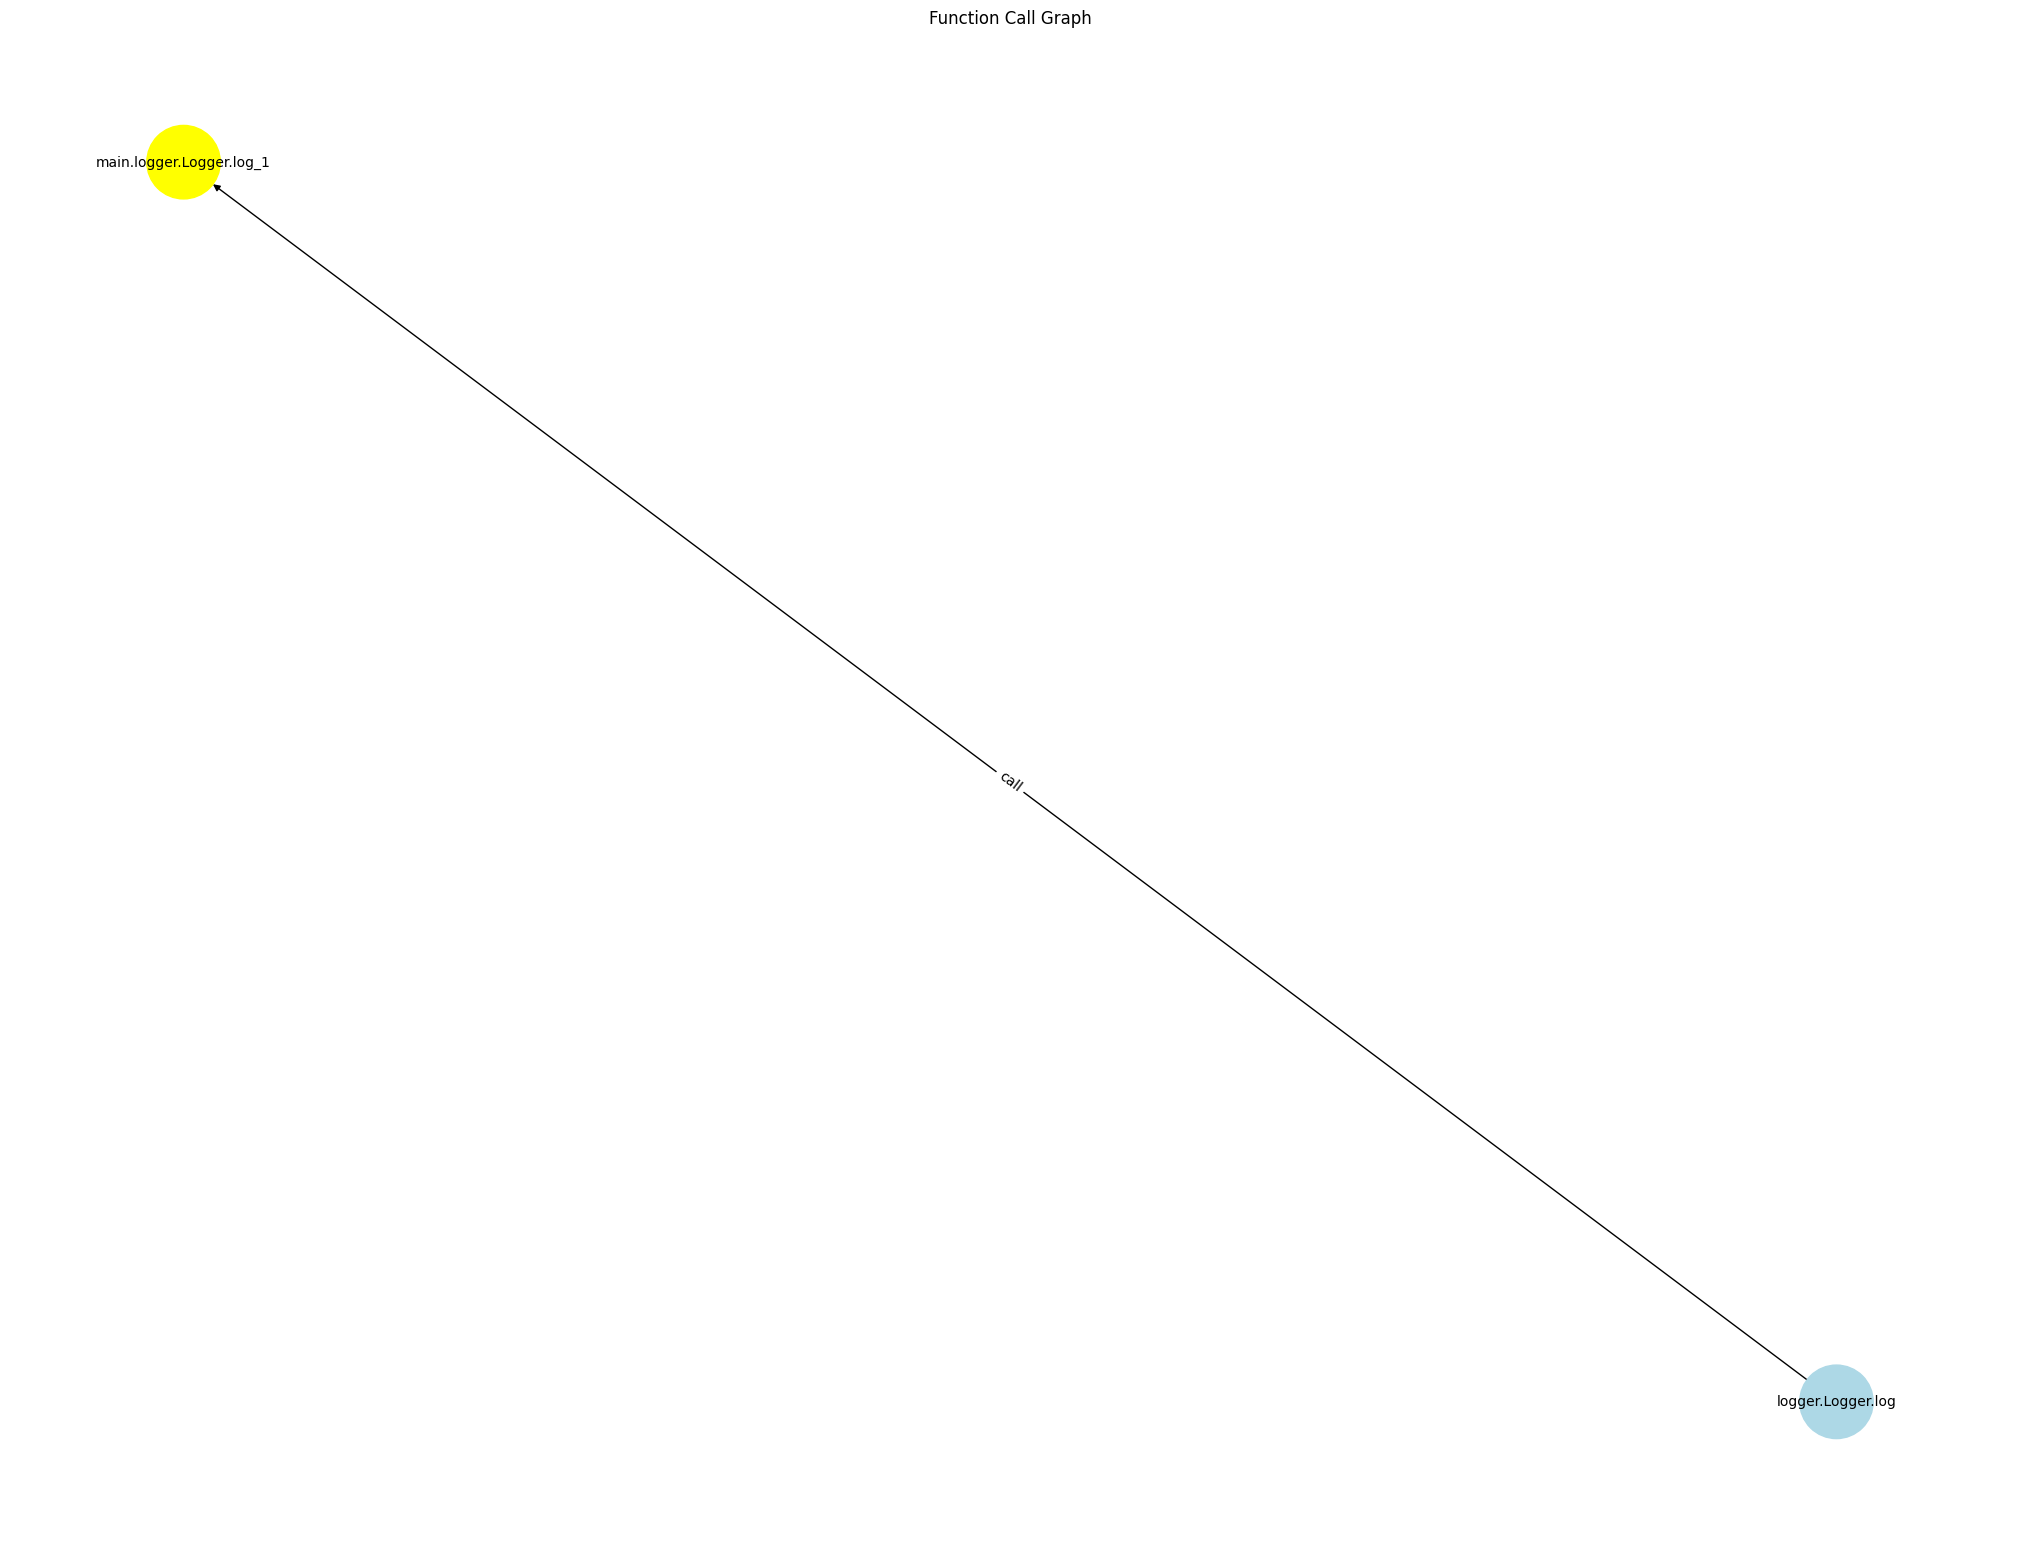

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
2024-07-07 23:26:21.638000: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-07 23:26:21.638112: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-07 23:26:21.797012: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



Updated Files
Updated Code for test_dir/main.py

from logger import Logger

logger = Logger()
logger.log("Hello, world!", log_level="INFO")
            
Updated Code for test_dir/logger.py

class Logger:
    
    def log(self, message: str, log_level: str = 'INFO'):
        if log_level == 'DEBUG':
            print(f"Debug: {message}")
        elif log_level == 'INFO':
            print(f"Info: {message}")
        elif log_level == 'WARNING':
            print(f"Warning: {message}")
        elif log_level == 'ERROR':
            print(f"Error: {message}")
        elif log_level == 'CRITICAL':
            print(f"Critical: {message}")
    
            

Testing code transformation

STATIC ANALYSIS
Analysis for test_dir/main.py
Transformed code is syntactically correct!
Analysis for test_dir/logger.py
Transformed code is syntactically correct!

DYNAMIC ANALYSIS
Analysis for test_dir/main.py
Similarity Ratio: 0.6666666666666666
Line Count Difference: 0
Analysis for test_dir/logger.py
Si

In [19]:
def transform_test_case():
    test_dir = 'test_dir'
    os.makedirs(test_dir, exist_ok=True)
    # Create sample files
    with open(os.path.join(test_dir, 'logger.py'), 'w') as f:
        f.write("""
class Logger:
    def log(self, message: str):
        print(f"Log: {message}")
            """)
            
    with open(os.path.join(test_dir, 'main.py'), 'w') as f:
        f.write("""
from logger import Logger

logger = Logger()
logger.log("Hello, world!")
            """)
    
    graph = build_graph(test_dir)
    print("Visualizing Repo Graph:")
    visualize_graph(graph)
    
    module_name = "logger"
    class_name = "Logger"
    function_name = "log"
    new_signature = "def log(self, message: str, log_level: str = 'INFO'):"
    modification_instruction = f"Add a new parameter `log_level` of type 'str' in the function 'log' and update the function body accordingly to adjust the new parameter. The function new signature should look like '{new_signature}'."
    output_dict = modify_function_and_calls(graph, module_name, class_name, function_name, modification_instruction)
    if output_dict:
        transformation_run_tests(output_dict)

transform_test_case()

### Another test case

Visualizing Repo Graph


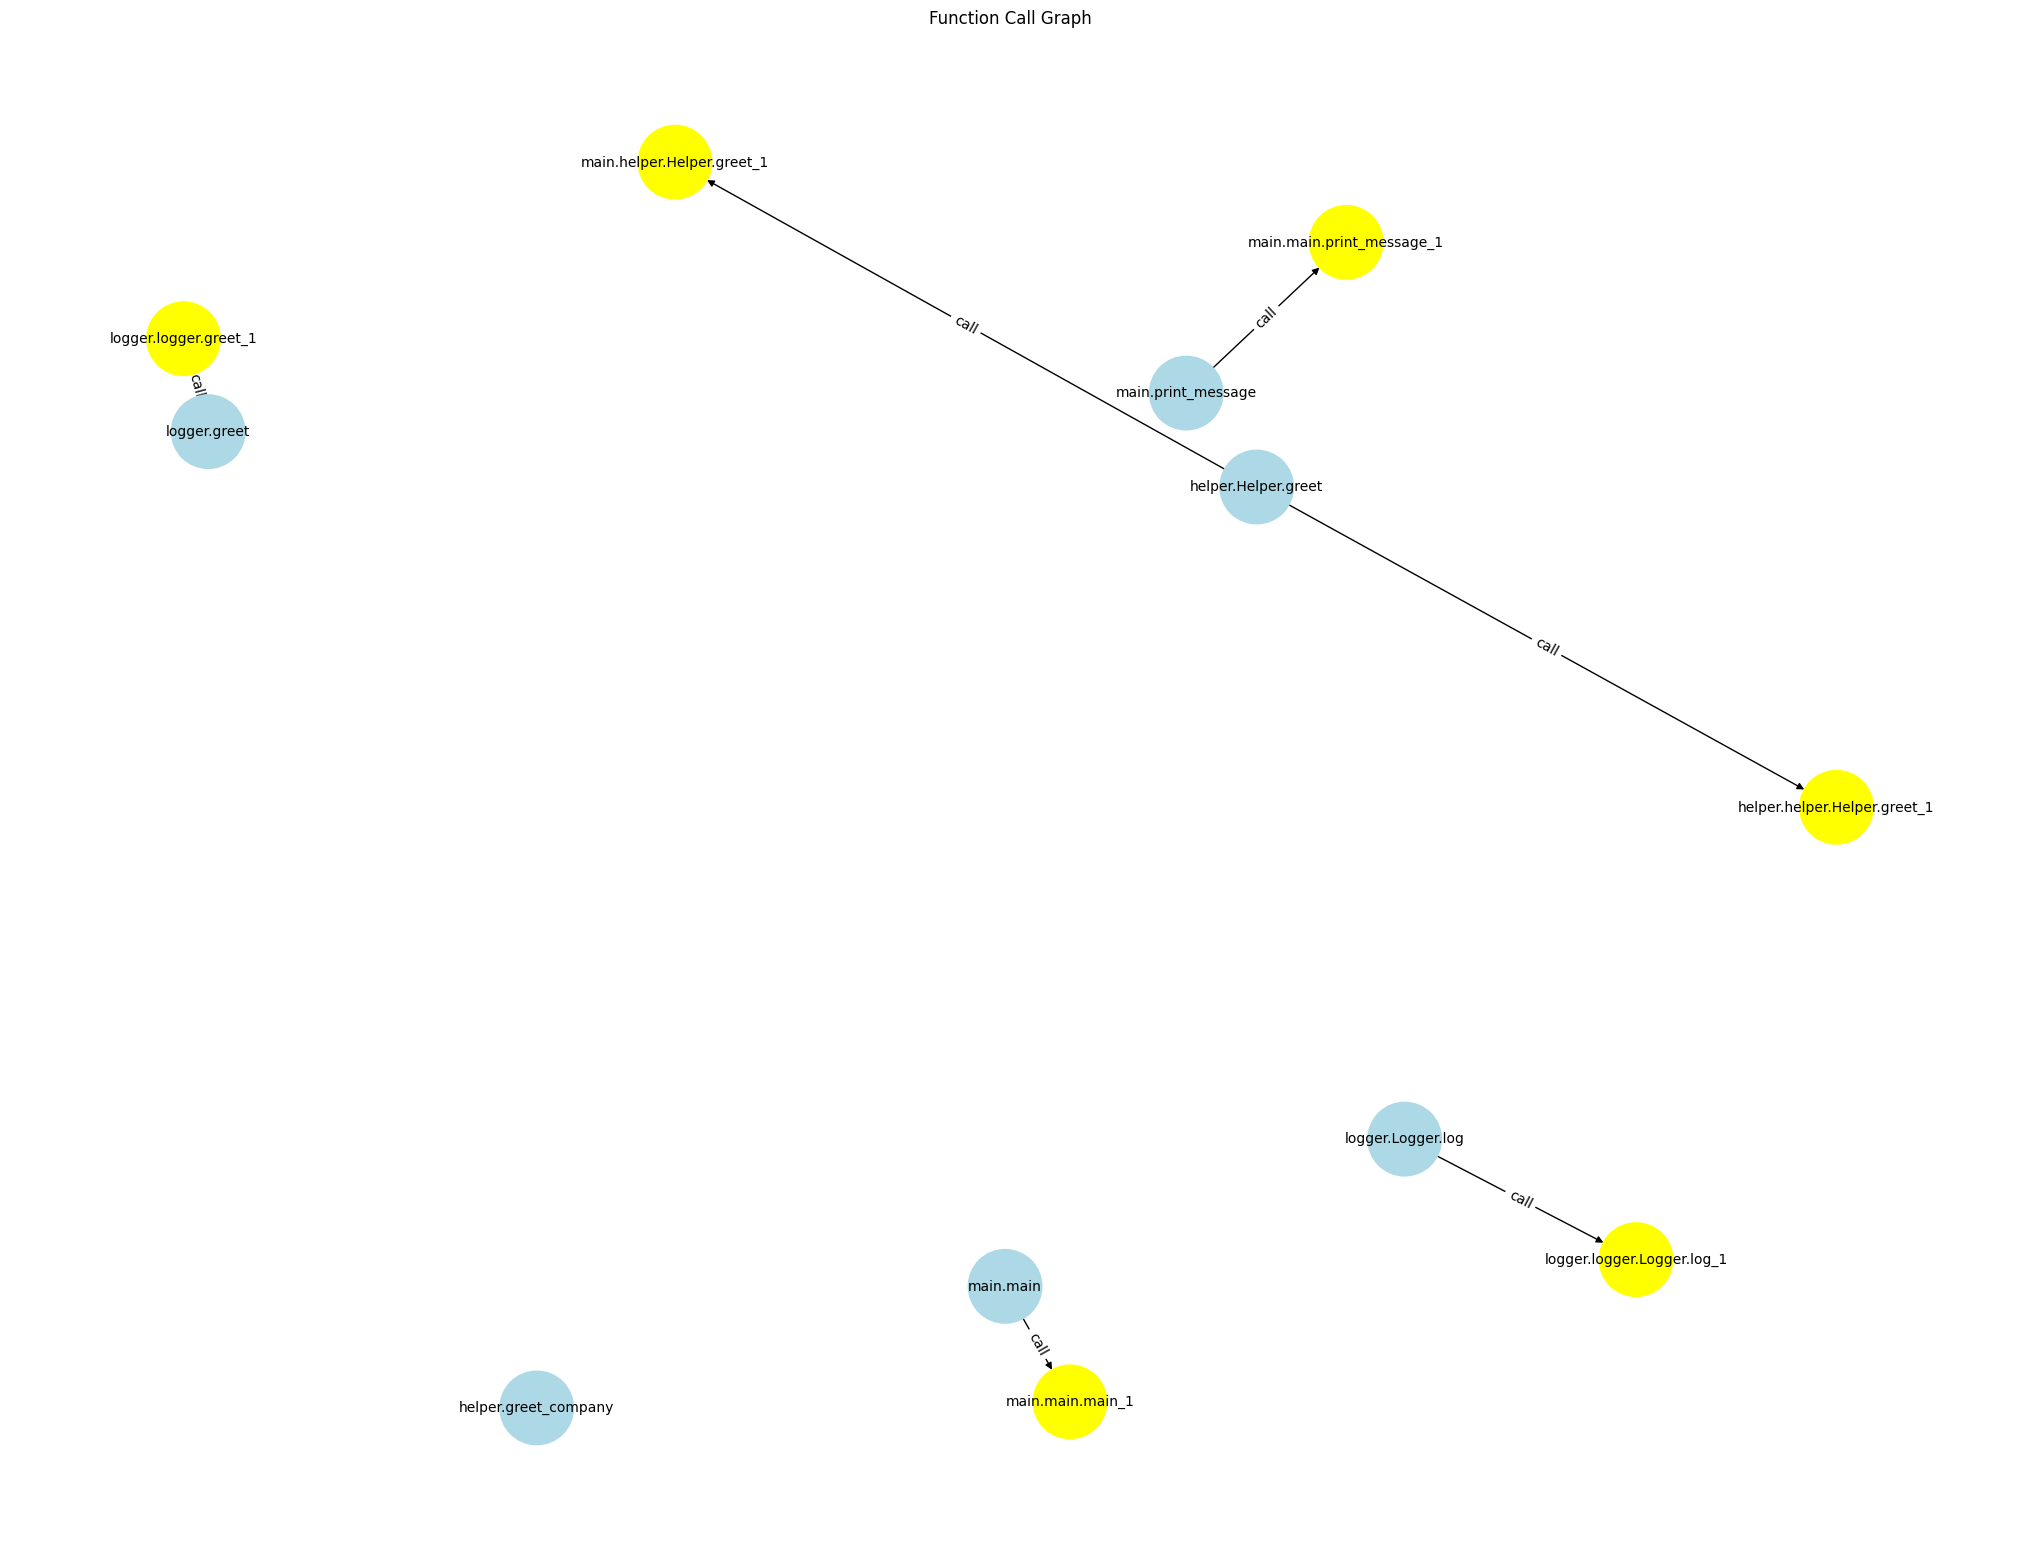

In [20]:
# Usage
repo_path = 'test_repo'
os.makedirs(repo_path, exist_ok=True)

# Main file
with open(os.path.join(repo_path, 'main.py'), 'w') as f:
    f.write('''
from helper import Helper, unused_function

def main():
    helper = Helper()
    company = "Apple"
    helper.greet("Alice", 50)
    unused_function(company)
    print_message("Hello from main")

def print_message(msg):
    print(msg)

if __name__ == "__main__":
    main()
''')

# Helper file
with open(os.path.join(repo_path, 'helper.py'), 'w') as f:
    f.write('''
class Helper:
    def greet(self, name:str, age:int):
        print(f"Hello, {name}! You are {age} years old.")

def greet_company(company, age):
    helper = Helper()
    helper.greet(name, age)

''')

# Logger File
with open(os.path.join(repo_path, 'logger.py'), 'w') as f:
    f.write('''
import numpy as np
class Logger():
    def log(self, message:str):
        print(message)
logger = Logger()
print("Hello, world!")
def greet(name: str, age=18, gender):
    a = [logger.log(name) for i in range(age) if gender == 'F']
    np.array(a)
    return "Hello, world!"
greet(gender = 'F')
''')

graph = build_graph(repo_path)
print("Visualizing Repo Graph")
visualize_graph(graph)

In [21]:
module_name = 'helper'
class_name = 'Helper'
function_name = 'greet'
modification_instruction = "Remove the parameter `age` from the function 'greet' and update the code accordingly to adjust the change. The function new signature should look like 'greet(name:str)'."
output_dict = modify_function_and_calls(graph, module_name, class_name, function_name, modification_instruction)
transformation_run_tests(output_dict)
# for file_name, code in modified_code_files.items():
#     with open(os.path.join(base_path, file_name), 'wb') as f:
#         f.write(code)

print("Function and calls have been modified successfully.")

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



Updated Files
Updated Code for test_repo/main.py

from helper import Helper, unused_function

def main():
    helper = Helper()
    company = "Apple"
    
    helper.greet("Alice")
    
    unused_function(company)
    print_message("Hello from main")

def print_message(msg):
    print(msg)

if __name__ == "__main__":
    main()

Updated Code for test_repo/helper.py

class Helper:
    
    def greet(self, name:str):
        print(f"Hello, {name}!")
    

def greet_company(company, age):
    helper = Helper()
    helper.greet(name, age)



Testing code transformation

STATIC ANALYSIS
Analysis for test_repo/main.py
Transformed code is syntactically correct!
Analysis for test_repo/helper.py
Transformed code is syntactically correct!

DYNAMIC ANALYSIS
Analysis for test_repo/main.py
Similarity Ratio: 0.7857142857142857
Line Count Difference: 2
Analysis for test_repo/helper.py
Similarity Ratio: 0.5
Line Count Difference: 2
ALL TESTS PERFORMED
Function and calls have been modified successful

### Insights:
1. For the two test cases, first test case was transformed accurately but in the second one of the function's caller was not transformed. 
2. Similarity ratio metric could be very useful for those files which have larger code because it could show if the transformed files are not drastically changes. This can also be observed in the test cases since the similarity ratio for that file where the function was defined drastically changed.
3. Line count difference can support the similarity ratio metric.
4. Static Analysis which is done to check for any compilation error and in both the cases code was syntactically correct.